# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [ ]:
!pip install segmentation-models-pytorch torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [ ]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 30
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [ ]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-8-b59c19bddbd4>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.2643, 0.2632, 0.2870,  ..., 0.2622, 0.2627, 0.2733],
         [0.2474, 0.2727, 0.2701,  ..., 0.2970, 0.2854, 0.2865],
         [0.2336, 0.2320, 0.2484,  ..., 0.2955, 0.2748, 0.3092],
         ...,
         [0.3335, 0.3277, 0.3578,  ..., 0.4815, 0.4746, 0.4720],
         [0.3330, 0.3388, 0.3076,  ..., 0.4868, 0.4868, 0.4778],
         [0.3187, 0.3134, 0.2659,  ..., 0.4878, 0.4921, 0.4831]],

        [[0.2941, 0.2865, 0.2995,  ..., 0.2628, 0.2713, 0.2865],
         [0.2793, 0.3057, 0.3017,  ..., 0.3066, 0.3013, 0.2968],
         [0.2520, 0.2511, 0.2686,  ..., 0.3120, 0.2914, 0.3205],
         ...,
         [0.3653, 0.3639, 0.3850,  ..., 0.4834, 0.4767, 0.4696],
         [0.3823, 0.3850, 0.3469,  ..., 0.4928, 0.4902, 0.4731],
         [0.3845, 0.3715, 0.3223,  ..., 0.4902, 0.4955, 0.4790]],

        [[0.3396, 0.3298, 0.3434,  ..., 0.2268, 0.2458, 0.2703],
         [0.3399, 0.3633, 0.3543,  ..., 0.3061, 0.2979, 0.2960],
         [0.3302, 0.3135, 0.3123,  ..., 0.3197, 0.2777, 0.

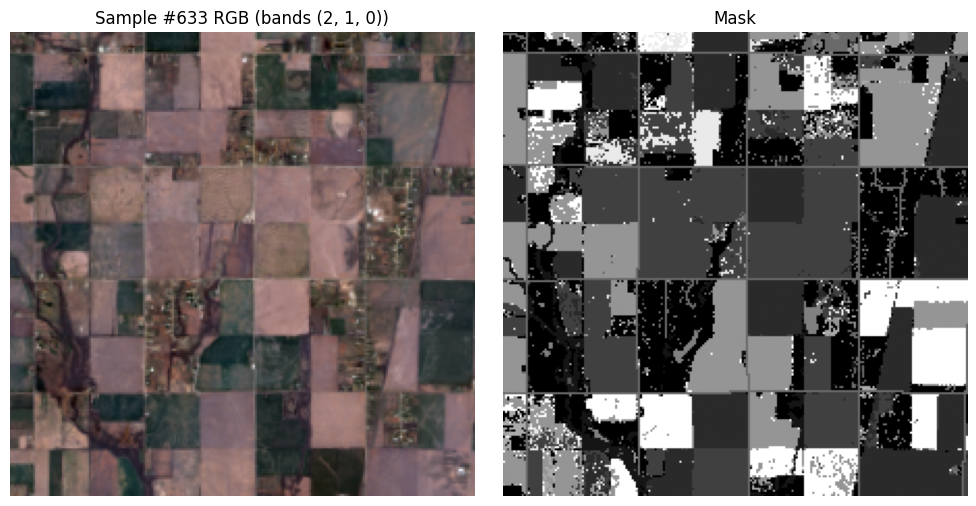

tensor([[[0.0636, 0.0753, 0.0794,  ..., 0.0412, 0.0416, 0.0502],
         [0.0755, 0.0770, 0.0823,  ..., 0.0338, 0.0362, 0.0589],
         [0.0803, 0.0792, 0.0852,  ..., 0.0146, 0.0150, 0.0617],
         ...,
         [0.1056, 0.0943, 0.0949,  ..., 0.0634, 0.0599, 0.0603],
         [0.1045, 0.0949, 0.0938,  ..., 0.0729, 0.0708, 0.0595],
         [0.0988, 0.0928, 0.0897,  ..., 0.0702, 0.0780, 0.0698]],

        [[0.0944, 0.0966, 0.1031,  ..., 0.0828, 0.0886, 0.0986],
         [0.0968, 0.0985, 0.1070,  ..., 0.0780, 0.0849, 0.1007],
         [0.0992, 0.1011, 0.1113,  ..., 0.0465, 0.0480, 0.0938],
         ...,
         [0.1361, 0.1295, 0.1312,  ..., 0.0856, 0.0793, 0.0834],
         [0.1381, 0.1294, 0.1294,  ..., 0.0929, 0.0897, 0.0817],
         [0.1366, 0.1294, 0.1262,  ..., 0.0893, 0.0975, 0.0916]],

        [[0.0785, 0.1054, 0.1093,  ..., 0.0639, 0.0591, 0.0681],
         [0.1033, 0.1090, 0.1139,  ..., 0.0551, 0.0516, 0.0757],
         [0.1128, 0.1111, 0.1176,  ..., 0.0384, 0.0322, 0.

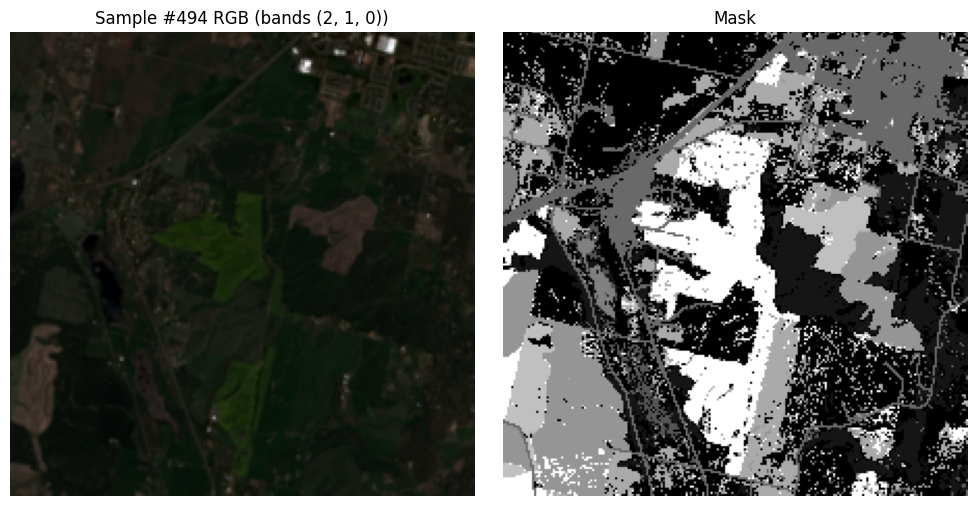

In [ ]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [ ]:
model = Unet(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True, ignore_index= 0)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0, ignore_index= 0 )
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );

def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    targets = targets.long()

    L_ce    = ce_loss(preds, targets)
    L_dice  = dice_loss(preds, targets)
    L_focal = focal_loss(preds, targets)

    return 0.6 * L_dice + 0.2 * L_ce + 0.2 * L_focal


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

<ipython-input-10-432393b78d55>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/30:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-8-b59c19bddbd4>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/30: 100%|██████████| 78/78 [14:16<00:00, 10.98s/it]


[Epoch  0] Loss:  1.6693, Acc:   0.0688, IoU:   0.0223, Dice:  0.0311, mIoU:  0.0198


Epoch 1/30 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch  0] Loss: 1.4807, Acc: 0.0715, IoU: 0.0171, Dice: 0.0268, mIoU: 0.0186


Epoch 2/30: 100%|██████████| 78/78 [06:34<00:00,  5.06s/it]


[Epoch  1] Loss:  1.3870, Acc:   0.0785, IoU:   0.0203, Dice:  0.0298, mIoU:  0.0200


Epoch 2/30 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


[Epoch  1] Loss: 1.2582, Acc: 0.0764, IoU: 0.0185, Dice: 0.0271, mIoU: 0.0181


Epoch 3/30: 100%|██████████| 78/78 [06:45<00:00,  5.20s/it]


[Epoch  2] Loss:  1.2024, Acc:   0.0810, IoU:   0.0294, Dice:  0.0371, mIoU:  0.0250


Epoch 3/30 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


[Epoch  2] Loss: 1.1843, Acc: 0.0852, IoU: 0.0325, Dice: 0.0455, mIoU: 0.0301


Epoch 4/30: 100%|██████████| 78/78 [06:20<00:00,  4.88s/it]


[Epoch  3] Loss:  1.1701, Acc:   0.0867, IoU:   0.0331, Dice:  0.0429, mIoU:  0.0290


Epoch 4/30 [Val]: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


[Epoch  3] Loss: 1.1785, Acc: 0.0744, IoU: 0.0203, Dice: 0.0305, mIoU: 0.0212


Epoch 5/30: 100%|██████████| 78/78 [06:21<00:00,  4.89s/it]


[Epoch  4] Loss:  1.1558, Acc:   0.0951, IoU:   0.0391, Dice:  0.0484, mIoU:  0.0329


Epoch 5/30 [Val]: 100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


[Epoch  4] Loss: 1.1573, Acc: 0.0986, IoU: 0.0414, Dice: 0.0515, mIoU: 0.0348


Epoch 6/30: 100%|██████████| 78/78 [06:48<00:00,  5.23s/it]


[Epoch  5] Loss:  1.1420, Acc:   0.1036, IoU:   0.0454, Dice:  0.0549, mIoU:  0.0378


Epoch 6/30 [Val]: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


[Epoch  5] Loss: 1.1501, Acc: 0.1076, IoU: 0.0469, Dice: 0.0563, mIoU: 0.0385


Epoch 7/30: 100%|██████████| 78/78 [06:37<00:00,  5.10s/it]


[Epoch  6] Loss:  1.1302, Acc:   0.1108, IoU:   0.0496, Dice:  0.0595, mIoU:  0.0413


Epoch 7/30 [Val]: 100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


[Epoch  6] Loss: 1.1371, Acc: 0.1170, IoU: 0.0544, Dice: 0.0641, mIoU: 0.0446


Epoch 8/30: 100%|██████████| 78/78 [06:26<00:00,  4.95s/it]


[Epoch  7] Loss:  1.1173, Acc:   0.1187, IoU:   0.0544, Dice:  0.0644, mIoU:  0.0450


Epoch 8/30 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


[Epoch  7] Loss: 1.1175, Acc: 0.1177, IoU: 0.0556, Dice: 0.0676, mIoU: 0.0472


Epoch 9/30: 100%|██████████| 78/78 [06:23<00:00,  4.91s/it]


[Epoch  8] Loss:  1.0941, Acc:   0.1352, IoU:   0.0665, Dice:  0.0748, mIoU:  0.0526


Epoch 9/30 [Val]: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


[Epoch  8] Loss: 1.1137, Acc: 0.1516, IoU: 0.0799, Dice: 0.0781, mIoU: 0.0551


Epoch 10/30: 100%|██████████| 78/78 [06:26<00:00,  4.96s/it]


[Epoch  9] Loss:  1.0610, Acc:   0.1769, IoU:   0.0940, Dice:  0.0901, mIoU:  0.0654


Epoch 10/30 [Val]: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


[Epoch  9] Loss: 1.0927, Acc: 0.1832, IoU: 0.0937, Dice: 0.0885, mIoU: 0.0634


Epoch 11/30: 100%|██████████| 78/78 [06:23<00:00,  4.91s/it]


[Epoch 10] Loss:  1.0313, Acc:   0.1951, IoU:   0.1070, Dice:  0.1011, mIoU:  0.0736


Epoch 11/30 [Val]: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


[Epoch 10] Loss: 1.0379, Acc: 0.2072, IoU: 0.1163, Dice: 0.1075, mIoU: 0.0775


Epoch 12/30: 100%|██████████| 78/78 [06:33<00:00,  5.05s/it]


[Epoch 11] Loss:  1.0105, Acc:   0.2069, IoU:   0.1157, Dice:  0.1096, mIoU:  0.0801


Epoch 12/30 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


[Epoch 11] Loss: 1.0404, Acc: 0.2155, IoU: 0.1197, Dice: 0.1088, mIoU: 0.0782


Epoch 13/30: 100%|██████████| 78/78 [06:29<00:00,  5.00s/it]


[Epoch 12] Loss:  0.9969, Acc:   0.2134, IoU:   0.1207, Dice:  0.1148, mIoU:  0.0841


Epoch 13/30 [Val]: 100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


[Epoch 12] Loss: 1.0140, Acc: 0.2136, IoU: 0.1215, Dice: 0.1158, mIoU: 0.0833


Epoch 14/30: 100%|██████████| 78/78 [07:09<00:00,  5.50s/it]


[Epoch 13] Loss:  0.9794, Acc:   0.2238, IoU:   0.1283, Dice:  0.1208, mIoU:  0.0889


Epoch 14/30 [Val]: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


[Epoch 13] Loss: 1.0023, Acc: 0.2188, IoU: 0.1255, Dice: 0.1197, mIoU: 0.0869


Epoch 15/30: 100%|██████████| 78/78 [07:11<00:00,  5.53s/it]


[Epoch 14] Loss:  0.9652, Acc:   0.2320, IoU:   0.1351, Dice:  0.1264, mIoU:  0.0933


Epoch 15/30 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.22s/it]


[Epoch 14] Loss: 0.9840, Acc: 0.2302, IoU: 0.1355, Dice: 0.1285, mIoU: 0.0943


Epoch 16/30: 100%|██████████| 78/78 [06:37<00:00,  5.10s/it]


[Epoch 15] Loss:  0.9518, Acc:   0.2420, IoU:   0.1436, Dice:  0.1327, mIoU:  0.0982


Epoch 16/30 [Val]: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


[Epoch 15] Loss: 0.9742, Acc: 0.2530, IoU: 0.1491, Dice: 0.1340, mIoU: 0.0982


Epoch 17/30: 100%|██████████| 78/78 [06:33<00:00,  5.04s/it]


[Epoch 16] Loss:  0.9397, Acc:   0.2680, IoU:   0.1660, Dice:  0.1468, mIoU:  0.1090


Epoch 17/30 [Val]: 100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


[Epoch 16] Loss: 0.9564, Acc: 0.3052, IoU: 0.1931, Dice: 0.1552, mIoU: 0.1153


Epoch 18/30: 100%|██████████| 78/78 [06:32<00:00,  5.04s/it]


[Epoch 17] Loss:  0.9176, Acc:   0.3046, IoU:   0.1960, Dice:  0.1630, mIoU:  0.1230


Epoch 18/30 [Val]: 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


[Epoch 17] Loss: 0.9365, Acc: 0.3149, IoU: 0.2027, Dice: 0.1632, mIoU: 0.1240


Epoch 19/30: 100%|██████████| 78/78 [06:32<00:00,  5.03s/it]


[Epoch 18] Loss:  0.8993, Acc:   0.3146, IoU:   0.2044, Dice:  0.1697, mIoU:  0.1290


Epoch 19/30 [Val]: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


[Epoch 18] Loss: 0.9265, Acc: 0.3279, IoU: 0.2092, Dice: 0.1674, mIoU: 0.1262


Epoch 20/30: 100%|██████████| 78/78 [06:31<00:00,  5.02s/it]


[Epoch 19] Loss:  0.8866, Acc:   0.3247, IoU:   0.2121, Dice:  0.1745, mIoU:  0.1334


Epoch 20/30 [Val]: 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


[Epoch 19] Loss: 0.9140, Acc: 0.3067, IoU: 0.1953, Dice: 0.1695, mIoU: 0.1292


Epoch 21/30: 100%|██████████| 78/78 [06:27<00:00,  4.97s/it]


[Epoch 20] Loss:  0.8759, Acc:   0.3325, IoU:   0.2187, Dice:  0.1798, mIoU:  0.1379


Epoch 21/30 [Val]: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


[Epoch 20] Loss: 0.9080, Acc: 0.3358, IoU: 0.2202, Dice: 0.1774, mIoU: 0.1356


Epoch 22/30: 100%|██████████| 78/78 [06:28<00:00,  4.98s/it]


[Epoch 21] Loss:  0.8652, Acc:   0.3411, IoU:   0.2263, Dice:  0.1844, mIoU:  0.1417


Epoch 22/30 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


[Epoch 21] Loss: 0.9006, Acc: 0.3446, IoU: 0.2249, Dice: 0.1790, mIoU: 0.1372


Epoch 23/30: 100%|██████████| 78/78 [06:39<00:00,  5.12s/it]


[Epoch 22] Loss:  0.8568, Acc:   0.3509, IoU:   0.2349, Dice:  0.1891, mIoU:  0.1462


Epoch 23/30 [Val]: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


[Epoch 22] Loss: 0.8897, Acc: 0.3336, IoU: 0.2184, Dice: 0.1844, mIoU: 0.1405


Epoch 24/30: 100%|██████████| 78/78 [07:02<00:00,  5.41s/it]


[Epoch 23] Loss:  0.8491, Acc:   0.3602, IoU:   0.2424, Dice:  0.1934, mIoU:  0.1500


Epoch 24/30 [Val]: 100%|██████████| 20/20 [01:11<00:00,  3.57s/it]


[Epoch 23] Loss: 0.8871, Acc: 0.3635, IoU: 0.2394, Dice: 0.1861, mIoU: 0.1427


Epoch 25/30: 100%|██████████| 78/78 [06:27<00:00,  4.97s/it]


[Epoch 24] Loss:  0.8378, Acc:   0.3676, IoU:   0.2497, Dice:  0.1971, mIoU:  0.1530


Epoch 25/30 [Val]: 100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


[Epoch 24] Loss: 0.8915, Acc: 0.3447, IoU: 0.2250, Dice: 0.1864, mIoU: 0.1446


Epoch 26/30: 100%|██████████| 78/78 [06:30<00:00,  5.01s/it]


[Epoch 25] Loss:  0.8310, Acc:   0.3793, IoU:   0.2582, Dice:  0.2016, mIoU:  0.1576


Epoch 26/30 [Val]: 100%|██████████| 20/20 [01:40<00:00,  5.00s/it]


[Epoch 25] Loss: 0.8781, Acc: 0.3562, IoU: 0.2351, Dice: 0.1931, mIoU: 0.1486


Epoch 27/30: 100%|██████████| 78/78 [06:33<00:00,  5.04s/it]


[Epoch 26] Loss:  0.8227, Acc:   0.3912, IoU:   0.2685, Dice:  0.2059, mIoU:  0.1613


Epoch 27/30 [Val]: 100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


[Epoch 26] Loss: 0.8763, Acc: 0.3567, IoU: 0.2397, Dice: 0.1936, mIoU: 0.1485


Epoch 28/30: 100%|██████████| 78/78 [06:39<00:00,  5.12s/it]


[Epoch 27] Loss:  0.8125, Acc:   0.4030, IoU:   0.2782, Dice:  0.2104, mIoU:  0.1651


Epoch 28/30 [Val]: 100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


[Epoch 27] Loss: 0.8723, Acc: 0.3687, IoU: 0.2402, Dice: 0.1956, mIoU: 0.1511


Epoch 29/30: 100%|██████████| 78/78 [06:37<00:00,  5.09s/it]


[Epoch 28] Loss:  0.8065, Acc:   0.4159, IoU:   0.2855, Dice:  0.2127, mIoU:  0.1675


Epoch 29/30 [Val]: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


[Epoch 28] Loss: 0.8665, Acc: 0.3691, IoU: 0.2510, Dice: 0.1971, mIoU: 0.1554


Epoch 30/30: 100%|██████████| 78/78 [06:24<00:00,  4.94s/it]


[Epoch 29] Loss:  0.7936, Acc:   0.4328, IoU:   0.2986, Dice:  0.2176, mIoU:  0.1733


Epoch 30/30 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]

[Epoch 29] Loss: 0.8635, Acc: 0.3841, IoU: 0.2563, Dice: 0.2027, mIoU: 0.1580


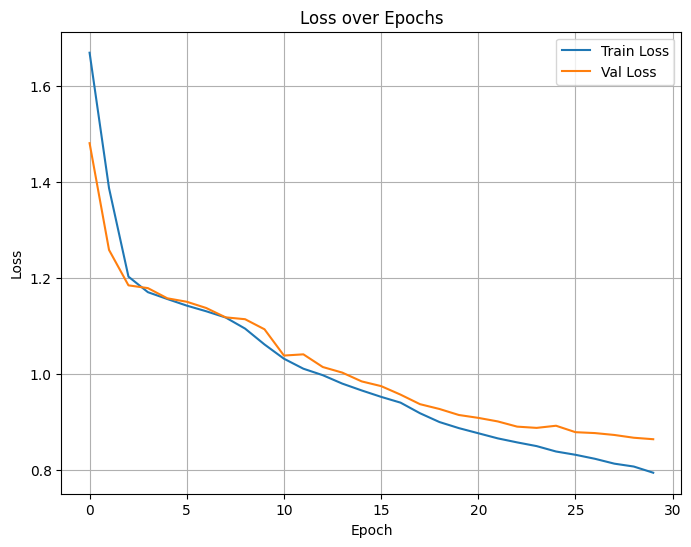

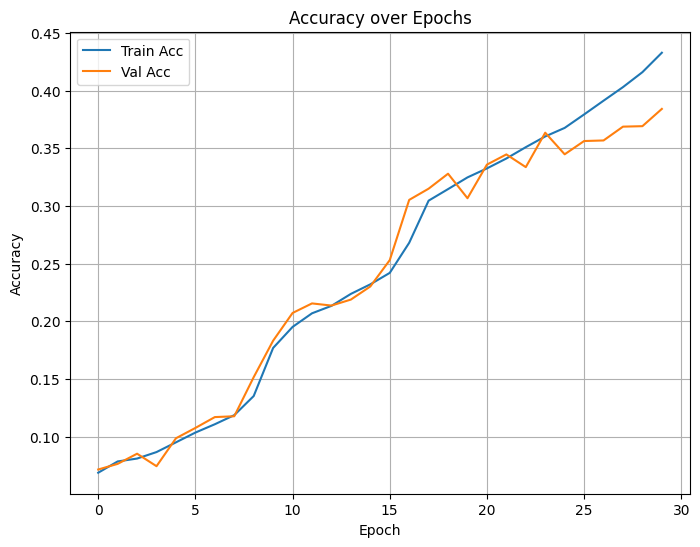

In [12]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_loss_20250513-145010_normalized.png


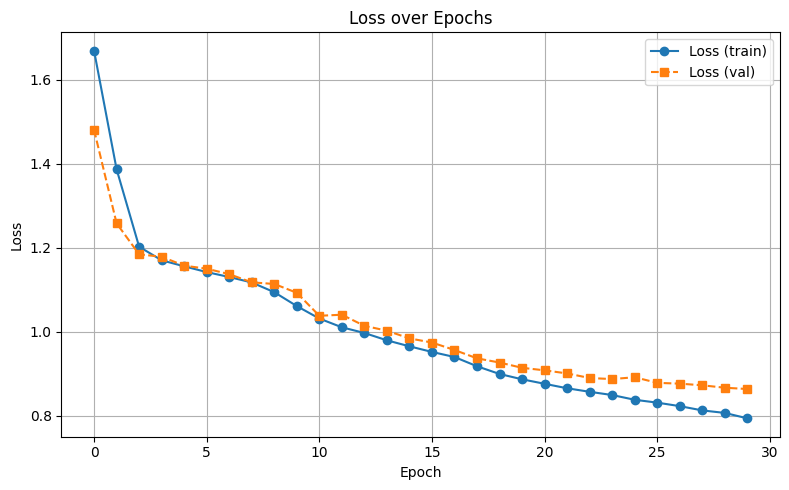

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_accuracy_20250513-145010_normalized.png


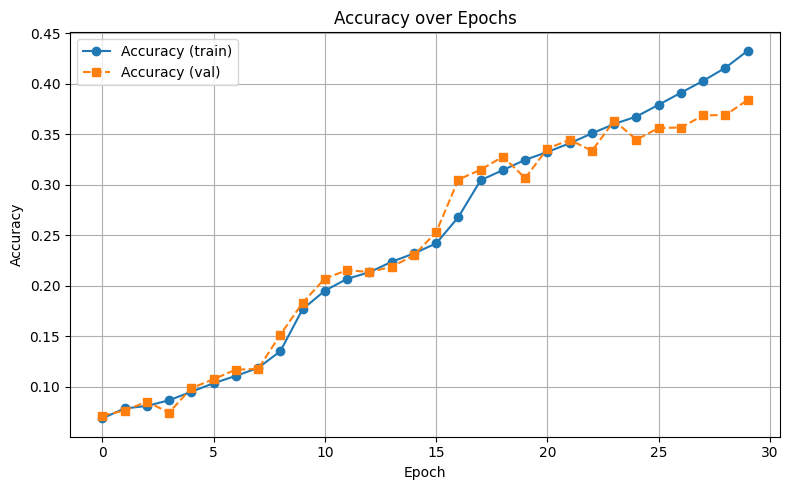

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_iou_20250513-145010_normalized.png


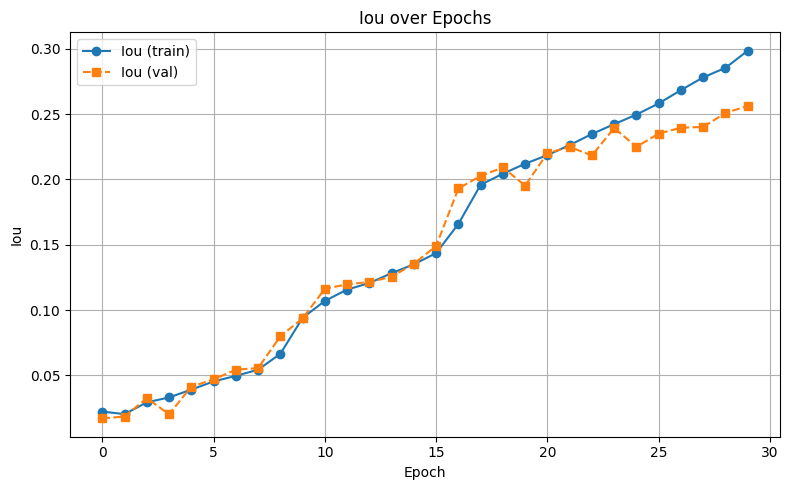

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_dice_20250513-145010_normalized.png


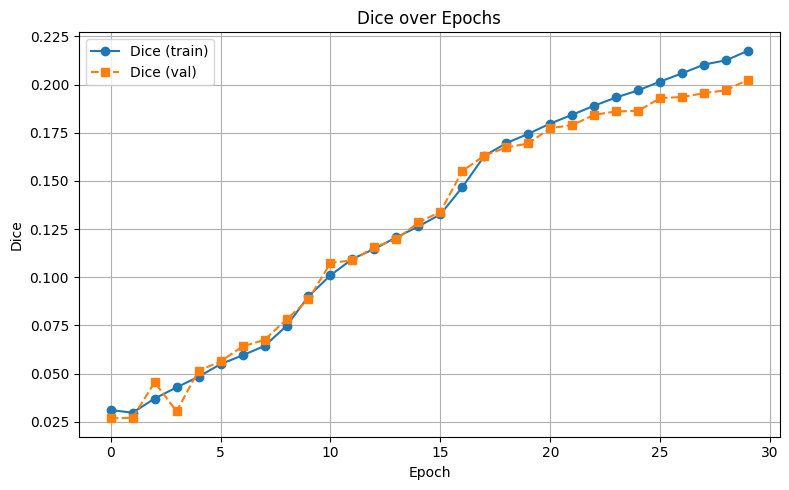

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_miou_20250513-145010_normalized.png


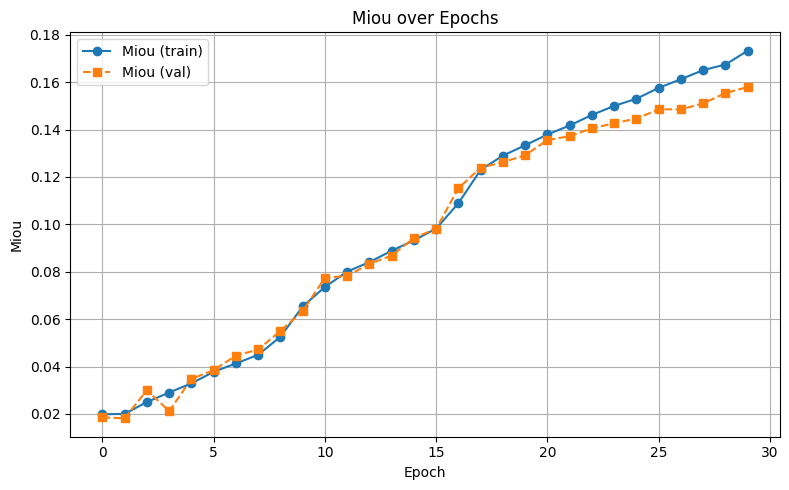

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [14]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/models/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_normalized.pth


In [15]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/metrics/unet_efficientnet-b4_imagenet_32bs_30ep_lr1e-04_normalized_metrics.csv
